In [1]:
#Adapted from: https://www.youtube.com/watch?v=UuteCccDXCE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=8

import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = True

In [3]:
class DogsVSCats():
  IMG_SIZE = 50
  CATS = "C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Cat"
  DOGS = "C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Dog"
  LABELS = {CATS:0,DOGS:1}
  
  training_data = []
  catcount = 0
  dogcount = 0
  
  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label,f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
          
          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1
        except Exception as e:
          pass
          #print(str(e))
          
    np.random.shuffle(self.training_data)
    np.save("C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/training_data.npy", self.training_data)
    print("Cats: ", self.catcount)
    print("Dogs: ", self.dogcount)
    
if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Cat


100%|███████████████████████████████████████████████████████████████████████████| 12491/12491 [00:44<00:00, 278.63it/s]


C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12470/12470 [00:48<00:00, 259.36it/s]
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Cats:  12469
Dogs:  12444


In [4]:
training_data = np.load("C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/training_data.npy", allow_pickle=True)

In [5]:
print(len(training_data))

24913


In [6]:
print(training_data[0])

[array([[159, 159, 161, ..., 136, 133, 132],
        [158, 162, 163, ..., 137, 137, 137],
        [161, 160, 162, ..., 140, 138, 137],
        ...,
        [201, 204, 205, ..., 192, 209, 150],
        [205, 204, 203, ...,  39,  37,  35],
        [204, 205, 199, ...,  90,  75,  30]], dtype=uint8) array([1., 0.])]


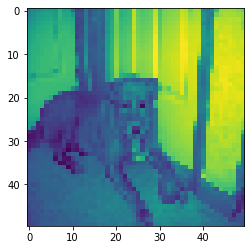

[0. 1.]


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(training_data[1][0])
plt.show()
print(training_data[1][1])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)
    x = torch.randn(50,50).view(-1,1,50,50)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)
  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

In [10]:
device = torch.device("cpu")
net = Net().to(device)

In [11]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2491


In [12]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22422
2491


In [13]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()

  return acc, loss

In [14]:
import numpy as np
def test(size=32):
  random_start = np.random.randint(len(test_X)-size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size] 
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
  return val_acc, val_loss
  
val_acc, val_loss = test()
print(val_acc, val_loss)

0.5625 tensor(0.2482)


In [15]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
  BATCH_SIZE = 100
  EPOCHS = 8 
  with open("C:/Users/rub12531/Downloads/archive/kagglecatsanddogs_3367a/PetImages/model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i % 50 == 0:
          val_acc, val_loss = test(size=100)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_loss),4)},{round(float(val_loss),4)}\n")
          
train()

model-1658601658


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:06<00:00,  1.78it/s]


In [54]:
testing = train_X[21:22].view(-1,1,50,50).to(device)
outputs = net(testing)
print(outputs)


tensor([[0.0503, 0.9497]], grad_fn=<SoftmaxBackward>)


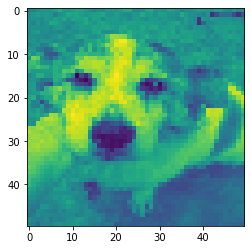

tensor([[0., 1.]])


In [55]:
res = train_X[21:22]
lab = train_y[21:22]

ima = np.array(res[0])

%matplotlib inline
plt.imshow(ima)
plt.show()

print(lab)